In [14]:
%matplotlib inline
import nengo
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nengo_dl

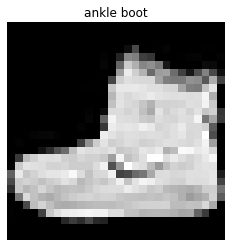

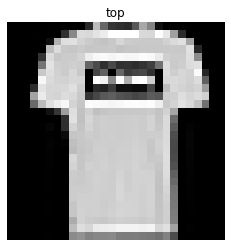

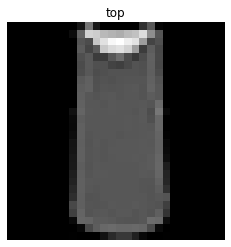

In [15]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# normalize images so values are between 0 and 1
# x_train = x_train / 255.0
# x_test = x_test / 255.0

# flatten images
x_train = x_train.reshape((x_train.shape[0], -1))
x_test = x_test.reshape((x_test.shape[0], -1))
# reshape images
#x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
#x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)


# initialize the label names
labelNames = ["top", "trouser", "pullover", "dress", "coat",
              "sandal", "shirt", "sneaker", "bag", "ankle boot"]
num_classes = len(labelNames)
for i in range(3):
    plt.figure()
    plt.imshow(np.reshape(x_train[i], (28, 28)),
               cmap="gray")
    plt.axis('off')
    plt.title(str(labelNames[y_train[i]]));

In [16]:
model = nengo.Network()
with model:
    # set some default parameters for the neurons that will make
    # the training progress more smoothly
    model.config[nengo.Ensemble].max_rates = nengo.dists.Choice([100])
    model.config[nengo.Ensemble].intercepts = nengo.dists.Choice([0])
    model.config[nengo.Connection].synapse = None
    neuron_type = nengo.LIF(amplitude=0.01)

    # this is an optimization to improve the training speed,
    # since we won't require stateful behaviour in this example
    nengo_dl.configure_settings(stateful=False)

    # the input node that will be used to feed in input images
    inp = nengo.Node(np.zeros(28 * 28))

    # add the first convolutional layer
    x = nengo_dl.Layer(tf.keras.layers.Conv2D(
        filters=32, kernel_size=3))(inp, shape_in=(28, 28, 1))
    x = nengo_dl.Layer(neuron_type)(x)

    # add the second convolutional layer
    x = nengo_dl.Layer(tf.keras.layers.Conv2D(
        filters=64, strides=2, kernel_size=3))(x, shape_in=(26, 26, 32))
    x = nengo_dl.Layer(neuron_type)(x)

    # add the third convolutional layer
    x = nengo_dl.Layer(tf.keras.layers.Conv2D(
        filters=128, strides=2, kernel_size=3))(x, shape_in=(12, 12, 64))
    x = nengo_dl.Layer(neuron_type)(x)

    # linear readout
    out = nengo_dl.Layer(tf.keras.layers.Dense(units=10))(x)

    # we'll create two different output probes, one with a filter
    # (for when we're simulating the network over time and
    # accumulating spikes), and one without (for when we're
    # training the network using a rate-based approximation)
    out_p = nengo.Probe(out, label="out_p")
    out_p_filt = nengo.Probe(out, synapse=0.1, label="out_p_filt")

In [17]:
minibatch_size = 200
sim = nengo_dl.Simulator(model, minibatch_size=minibatch_size)

Build finished in 0:00:00                                                      
Optimization finished in 0:00:01                                               


In [18]:
# unlike in Keras, NengoDl simulations always run over time.
# so we need to add the time dimension to our data (even though
# in this case we'll just run for a single timestep).
x_train = x_train[:, None, :]
y_train = y_train[:, None, None]

n_steps = 30
x_test = np.tile(x_test[:, None, :],
                      (1, n_steps, 1))
y_test = np.tile(y_test[:, None, None],
                      (1, n_steps, 1))

In [19]:
def classification_accuracy(y_true, y_pred):
    return tf.metrics.sparse_categorical_accuracy(
        y_true[:, -1], y_pred[:, -1])

In [ ]:
# note that we use `out_p_filt` when testing (to reduce the spike noise)
sim.compile(loss={out_p_filt: classification_accuracy})
print("accuracy before training:",
sim.evaluate(x_test, {out_p_filt: y_test}, verbose=0)["loss"])

In [20]:
sim.compile(
    optimizer=tf.optimizers.RMSprop(0.001),
    loss={out_p: tf.losses.SparseCategoricalCrossentropy(from_logits=True)}
)
sim.fit(x_train, {out_p: y_train}, epochs=20)

c:\users\unaig\desktop\experimentacion\ai\nengodl\nengo-dl\nengo_dl\simulator.py:1941: RuntimeWarning: Simulator with model=Model: <Network (unlabeled) at 0x1a02b48cfd0>, dt=0.001000 was deallocated while open. Simulators should be closed manually to ensure resources are properly freed.
  RuntimeWarning,


Train on 60000 samples
Epoch 1/20
60000/60000 [==============================] - 64s 1ms/sample - loss: 0.5653 - out_p_loss: 0.5653
Epoch 2/20
60000/60000 [==============================] - 32s 526us/sample - loss: 0.3825 - out_p_loss: 0.3825
Epoch 3/20
60000/60000 [==============================] - 32s 526us/sample - loss: 0.3447 - out_p_loss: 0.3447
Epoch 4/20
60000/60000 [==============================] - 32s 525us/sample - loss: 0.3150 - out_p_loss: 0.3150
Epoch 5/20
60000/60000 [==============================] - 32s 532us/sample - loss: 0.2959 - out_p_loss: 0.2959
Epoch 6/20
60000/60000 [==============================] - 195s 3ms/sample - loss: 0.2776 - out_p_loss: 0.2776
Epoch 7/20
60000/60000 [==============================] - 106s 2ms/sample - loss: 0.2642 - out_p_loss: 0.2642
Epoch 8/20
60000/60000 [==============================] - 110s 2ms/sample - loss: 0.2585 - out_p_loss: 0.2585
Epoch 9/20
60000/60000 [==============================] - 111s 2ms/sample - loss: 0.2581 - out

In [21]:
# save the parameters to file
sim.save_params("./fashion-mnist_params")

In [22]:
sim.compile(loss={out_p_filt: classification_accuracy})
print("accuracy after training:",
sim.evaluate(x_test, {out_p_filt: y_test}, verbose=0)["loss"])

accuracy after training: 0.8704000008106232


In [23]:
sim.close()

Load params

In [26]:
sim = nengo_dl.Simulator(model, minibatch_size=minibatch_size)
sim.load_params("./fashion-mnist_params")

Build finished in 0:00:00                                                      
Optimization finished in 0:00:01                                               


c:\users\unaig\desktop\experimentacion\ai\nengodl\nengo-dl\nengo_dl\simulator.py:1941: RuntimeWarning: Simulator with model=Model: <Network (unlabeled) at 0x1a02b9c7a90>, dt=0.001000 was deallocated while open. Simulators should be closed manually to ensure resources are properly freed.
  RuntimeWarning,


In [30]:
(_, _), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

x_test = x_test.reshape((x_test.shape[0], -1))

n_steps = 100
x_test = np.tile(x_test[:, None, :],
                      (1, n_steps, 1))
y_test = np.tile(y_test[:, None, None],
                      (1, n_steps, 1))

In [31]:
sim.compile(loss={out_p_filt: classification_accuracy})
print("accuracy after training:",
sim.evaluate(x_test, {out_p_filt: y_test}, verbose=0)["loss"])

accuracy after training: 0.875


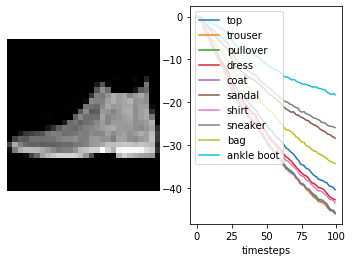

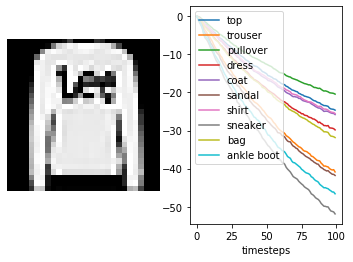

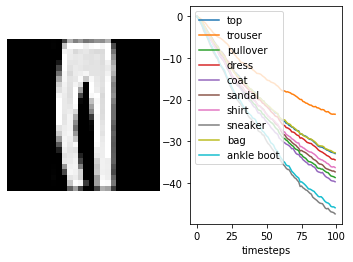

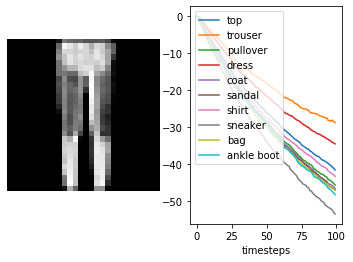

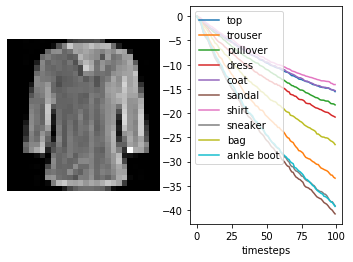

In [33]:
data = sim.predict(x_test[:minibatch_size])

for i in range(5):
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(x_test[i, 0].reshape((28, 28)), cmap="gray")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.plot(data[out_p_filt][i])
    plt.legend([str(labelNames[i]) for i in range(10)], loc="upper left")
    plt.xlabel("timesteps")